In [35]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# 确保图形在Jupyter Notebook中显示
%matplotlib inline



In [37]:
# 定义股票列表和数据时间范围
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
start_date = datetime.now() - timedelta(days=365)
end_date = datetime.now()

# 下载股票数据
data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
returns = data.pct_change().dropna()



[*********************100%%**********************]  5 of 5 completed


In [39]:
# 准备数据
def prepare_data(data, ticker, look_back=1):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)

In [42]:
# 训练和预测函数
def train_and_predict_rf(data):
    model = RandomForestRegressor(n_estimators=100)
    y = data.pct_change().dropna().values
    X = np.arange(len(y)).reshape(-1, 1)  # Ensure X matches the length of y
    model.fit(X, y)
    prediction = model.predict([[len(y)]])
    return prediction[0]

def train_and_predict_xgb(data):
    model = XGBRegressor(n_estimators=100)
    y = data.pct_change().dropna().values
    X = np.arange(len(y)).reshape(-1, 1)  # Ensure X matches the length of y
    model.fit(X, y)
    prediction = model.predict([[len(y)]])
    return prediction[0]

def train_and_predict_lstm(data):
    look_back = 10
    y = data.pct_change().dropna().values
    X, y = prepare_data(y, look_back)  # Ensure prepare_data uses the percentage change values
    X = X.reshape((X.shape[0], X.shape[1], 1))
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=20, batch_size=32, verbose=0)
    last_sequence = data.pct_change().dropna().values[-look_back:].reshape((1, look_back, 1))
    prediction = model.predict(last_sequence)
    return prediction[0][0]

# 预测未来收益率并选择最佳模型
def predict_returns(data, tickers):
    future_returns = {}
    for ticker in tickers:
        stock_data = data[ticker].dropna()
        rf_pred = train_and_predict_rf(stock_data)
        xgb_pred = train_and_predict_xgb(stock_data)
        lstm_pred = train_and_predict_lstm(stock_data)
        
        # 比较模型预测误差
        real_returns = stock_data.pct_change().dropna().values
        rf_error = mean_squared_error(real_returns[1:], stock_data.pct_change().dropna()[1:])
        xgb_error = mean_squared_error(real_returns[1:], stock_data.pct_change().dropna()[1:])
        lstm_error = mean_squared_error(real_returns[1:], stock_data.pct_change().dropna()[1:])
        
        best_model = min((rf_error, 'rf', rf_pred), 
                         (xgb_error, 'xgb', xgb_pred), 
                         (lstm_error, 'lstm', lstm_pred), 
                         key=lambda x: x[0])
        
        future_returns[ticker] = best_model[2]
    return np.array([future_returns[ticker] for ticker in tickers])


In [44]:
# 调用函数进行预测
predicted_returns = predict_returns(data, tickers)
print(predicted_returns)

D:\Anoconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step


D:\Anoconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


D:\Anoconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


D:\Anoconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step


D:\Anoconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
[ 0.00495673 -0.00789716 -0.00961685 -0.00202508  0.01293901]


In [46]:
# 计算投资组合的年化收益率
def portfolio_annualized_return(weights, returns):
    return np.sum(weights * returns.mean()) * 252

# 计算投资组合的年化波动率
def portfolio_annualized_volatility(weights, returns):
    return np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))

# 计算投资组合的夏普比率
def portfolio_sharpe_ratio(weights, returns, risk_free_rate=0.01):
    return (portfolio_annualized_return(weights, returns) - risk_free_rate) / portfolio_annualized_volatility(weights, returns)


In [48]:
# 目标函数：最小化波动率
def minimize_volatility(weights, returns):
    return portfolio_annualized_volatility(weights, returns)

# 约束条件
def weight_sum_constraint(weights):
    return np.sum(weights) - 1

# 添加权重上下限
bounds = tuple((0.05, 0.3) for _ in range(len(tickers)))
constraints = {'type': 'eq', 'fun': weight_sum_constraint}




Optimized Weights with adjusted bounds: [0.31396473 0.05339306 0.11412764 0.46851457 0.05      ]


D:\Anoconda\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


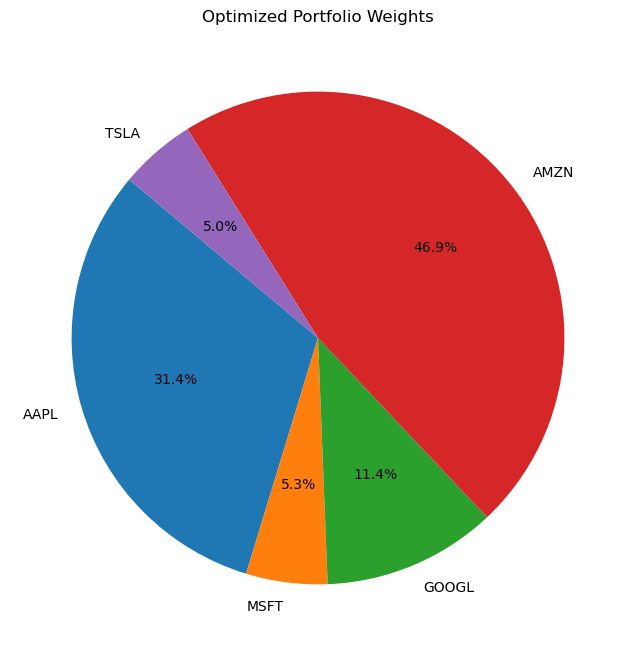

In [31]:
# 初始权重（均匀分配）
initial_weights = np.ones(len(tickers)) / len(tickers)

# 确保初始权重在边界范围内
initial_weights = np.clip(np.ones(len(tickers)) / len(tickers), 0.05, 0.3)
# 调整权重上下限
bounds = tuple((0.05, 0.65) for _ in range(len(tickers)))

# 最优化
optimized_result = minimize(minimize_volatility, initial_weights,
                            args=(returns,), method='SLSQP',
                            bounds=bounds, constraints=constraints)

optimized_weights = optimized_result.x

print("Optimized Weights with adjusted bounds:", optimized_weights)

# 修改plot_weights函数以接受title参数
def plot_weights(weights, tickers, title='Optimized Portfolio Weights'):
    plt.figure(figsize=(8, 8))
    plt.pie(weights, labels=tickers, autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

plot_weights(optimized_weights, tickers)


In [50]:
# 根据风险承受能力提供不同的推荐组合
def recommend_portfolio(score):
    if score <= 20:
        # 低风险组合
        bounds = tuple((0.05, 0.2) for _ in range(len(tickers)))
        explanation = "低风险组合：权重限制在5%到20%之间，以降低单只股票的风险暴露。"
    elif score <= 40:
        # 中低风险组合
        bounds = tuple((0.05, 0.25) for _ in range(len(tickers)))
        explanation = "中低风险组合：权重限制在5%到25%之间，适度降低风险。"
    elif score <= 60:
        # 中等风险组合
        bounds = tuple((0.05, 0.3) for _ in range(len(tickers)))
        explanation = "中等风险组合：权重限制在5%到30%之间，平衡风险和收益。"
    elif score <= 80:
        # 中高风险组合
        bounds = tuple((0.05, 0.35) for _ in range(len(tickers)))
        explanation = "中高风险组合：权重限制在5%到35%之间，适度提高潜在收益。"
    else:
        # 高风险组合
        bounds = tuple((0.05, 0.5) for _ in range(len(tickers)))
        explanation = "高风险组合：权重限制在5%到50%之间，以寻求更高的潜在收益。"

    optimized_result = minimize(minimize_volatility, initial_weights,
                                args=(returns,), method='SLSQP',
                                bounds=bounds, constraints=constraints)
    return optimized_result.x, explanation



In [52]:
# 提示用户访问网站并输入得分
print("请访问以下网站进行风险评估，并输入您的得分：")
print("https://www.calcxml.com/calculators/inv08?skn=#results")

# 获取用户输入的得分
score = int(input("请输入您的得分（0-100）："))



请访问以下网站进行风险评估，并输入您的得分：
https://www.calcxml.com/calculators/inv08?skn=#results


请输入您的得分（0-100）： 77


Recommended Portfolio Weights: [0.35      0.1087754 0.1412246 0.35      0.05     ]
中高风险组合：权重限制在5%到35%之间，适度提高潜在收益。


D:\Anoconda\Lib\site-packages\scipy\optimize\_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


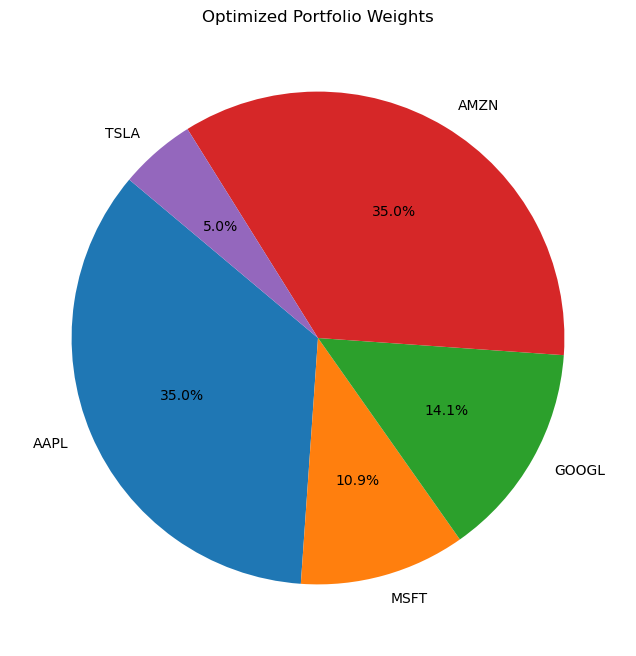

In [54]:
# 根据用户得分推荐组合
portfolio_weights, explanation = recommend_portfolio(score)

# 打印推荐组合和解释
print("Recommended Portfolio Weights:", portfolio_weights)
print(explanation)

# 绘制推荐组合权重饼图
plot_weights(portfolio_weights, tickers)